# Imports and functions

In [1]:
import h5py
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import argparse
from pathlib import Path
import matplotlib.cm as cm
import sys
import glob
import netCDF4
# from dea_tools.plotting import xr_animation
import os
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import odc.geo.xr
sys.path.append('/g/data/jk72/sc0554/dea-notebooks/Tools/dea_tools/')
from dea_tools.spatial import subpixel_contours
from spatial import subpixel_contours

In [2]:
def paths_to_datetimeindex(paths, string_slice=(0, 10), form='%Y%m'):
    """
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string.
    Parameters
    ----------
    paths : list of strings
        A list of file path strings that will be used to extract times
    string_slice : tuple
        An optional tuple giving the start and stop position that
        contains the time information in the provided paths. These are
        applied to the basename (i.e. file name) in each path, not the
        path itself. Defaults to (0, 10).
    Returns
    -------
    A pandas.DatetimeIndex object containing a 'datetime64[ns]' derived
    from the file paths provided by `paths`.
    """
    date_strings = [os.path.basename(i)[slice(*string_slice)]
                    for i in paths]
    return pd.to_datetime(date_strings, format=form)

# Create xarray / netcdf from h5 files

In [3]:
# Load and sort filelist by time

filelist=[]
path = '/g/data/jk72/MIZ/ICESat2/'
print("Finding files")
for file in Path(path).rglob('*.h5'):
    filelist.append(file)

filelist = sorted(filelist, key=lambda i: int(os.path.splitext(os.path.basename(i)[9:17])[0]))
print(f"Processing {len(filelist)} files")

# extract dimensions from top layer of h5 file
dims = xr.open_dataset(filelist[0])

Finding files
Processing 42 files


# Daily data

In [52]:
xrlist = []

for file in filelist:
    ncf = netCDF4.Dataset(file, diskless=True, persist=False)
    nch = ncf.groups.get('daily')
    for day in nch.groups.keys():
        ncd = nch.groups.get(day)
        xds = xr.open_dataset(xr.backends.NetCDF4DataStore(ncd))
        xrlist.append(xds.squeeze())

dates = xr.Variable('time', [i['delta_time_beg'].values for i in xrlist])        
daily_ATL20 = xr.concat(xrlist, dim=dates)
# Apply dimensions

daily_ATL20 = daily_ATL20.assign_coords({'grid_x':dims['grid_x'], 'grid_y':dims['grid_y']})

# Assign attributes

daily_ATL20 = daily_ATL20.assign_attrs(dims.attrs)

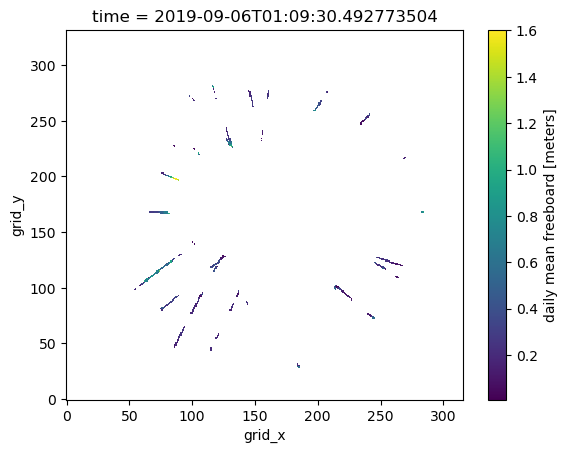

In [21]:
daily_ATL20['mean_fb'].isel(time=300).plot()

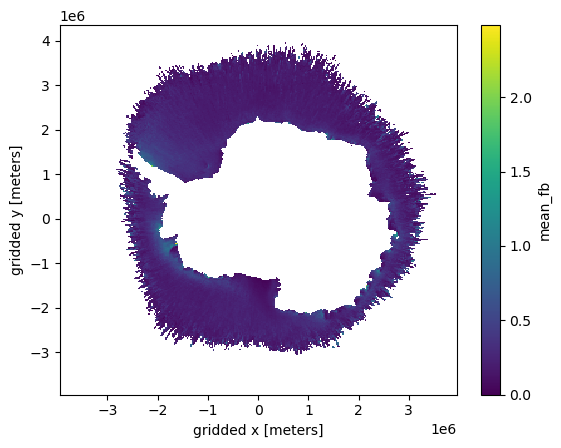

In [53]:
daily_ATL20['mean_fb'].mean(dim=['time']).plot()

In [74]:
daily_ATL20.to_netcdf('/g/data/jk72/sc0554/ATL20daily.nc')

In [3]:
daily_ATL20 = xr.open_dataset('/g/data/jk72/sc0554/ATL20daily.nc')

# Monthly data

In [10]:
# Create time index

time_var = xr.Variable('time', paths_to_datetimeindex(filelist,
                                                      string_slice=(9,15), form='%Y%m'))

# Concat individual monthly data

ds = xr.concat([xr.open_dataset(i, group='monthly').squeeze() for i in filelist],
                        dim=time_var)

# Apply dimensions

ds = ds.assign_coords({'grid_x':dims['grid_x'], 'grid_y':dims['grid_y']})

# Assign attributes

ds = ds.assign_attrs(dims.attrs)

# Calculate monthly mean

mean = ds['mean_fb'].groupby('time.month').mean('time', keep_attrs=True)

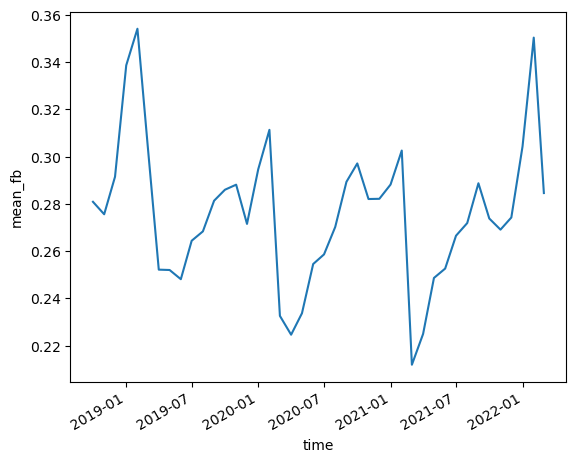

In [13]:
ds['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot()

In [ ]:
mean['month'].values

In [ ]:
# Plot one year of monthly freeboard

ds['mean_fb'].sel(time=slice("2021-01-01","2021-12-31")).plot(col="time", col_wrap=4, vmax=1)
plt.savefig('/g/data/jk72/sc0554/ATL20_mean_fb_2021')

In [ ]:
# Plot monthly all time means

mean.plot(col="month", col_wrap=4, vmax=0.7)
plt.savefig('/g/data/jk72/sc0554/ATL20_alltime_monthly_mean_fb.png')

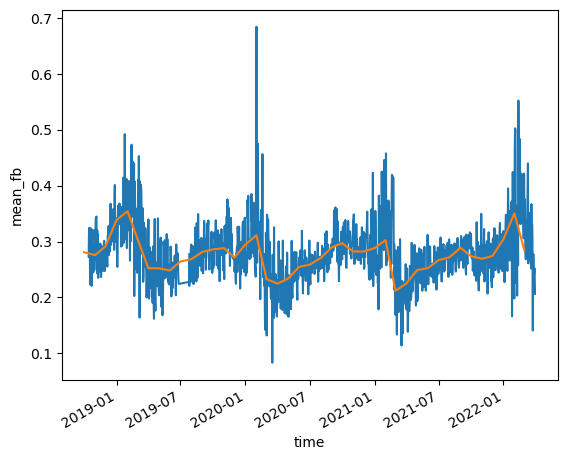

In [59]:
# Plot daily and monthly together

daily_ATL20['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot()
ds['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot()
plt.savefig('/g/data/jk72/sc0554/ATL20_dailyand_monthly.png')

In [ ]:
# Save data

ds.to_netcdf('/g/data/jk72/sc0554/ATL20.nc')

In [4]:
# Open and verify

ds = xr.open_dataset('/g/data/jk72/sc0554/ATL20.nc')

# Time series plotting

In [ ]:
mean = ds['mean_fb'].groupby('time.month').mean('time')

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
mean.isel(month=9).plot()
ax.ticklabel_format(useOffset=False)
ax.ticklabel_format(style='plain')

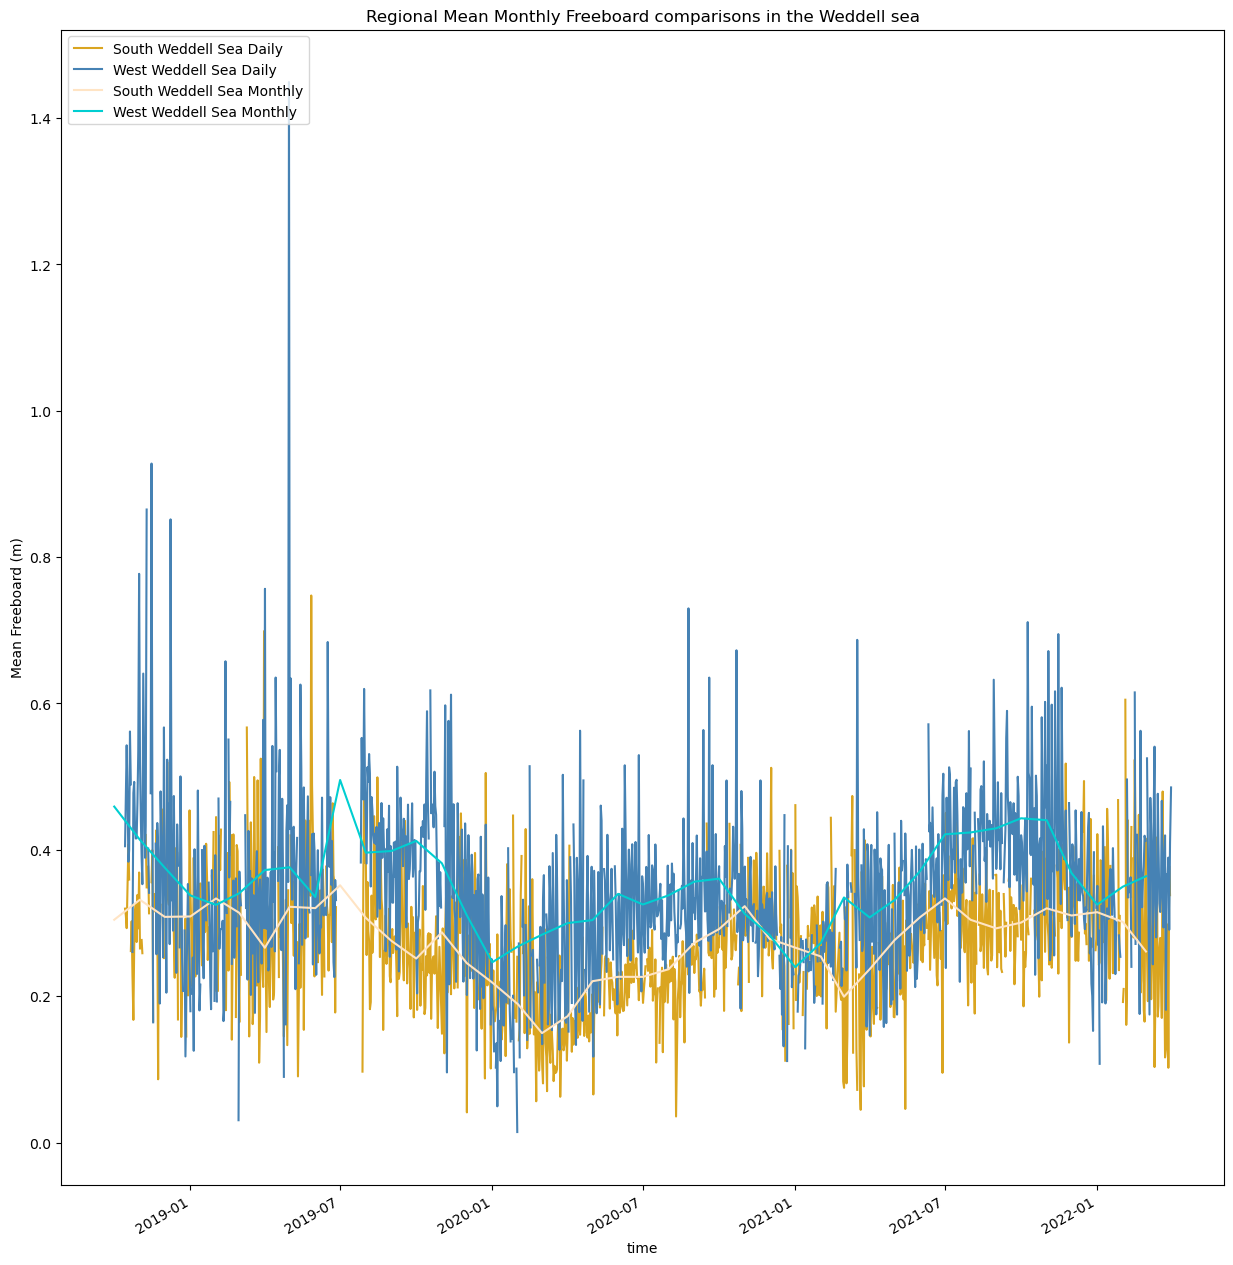

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
daily_ATL20.where((ds['grid_x'] > -1225655) & (ds['grid_x'] < -481459) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 1796829))['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot(x='time', ax=ax, label='South Weddell Sea Daily', color='goldenrod')
daily_ATL20.where((ds['grid_x'] < -1225655) & (ds['grid_x'] > -2193339) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 2193339))['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot(x='time', ax=ax, label='West Weddell Sea Daily', color='steelblue')

ds.where((ds['grid_x'] > -1225655) & (ds['grid_x'] < -481459) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 1796829))['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot(x='time', ax=ax, label='South Weddell Sea Monthly', color='bisque')
ds.where((ds['grid_x'] < -1225655) & (ds['grid_x'] > -2193339) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 2193339))['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot(x='time', ax=ax, label='West Weddell Sea Monthly', color='darkturquoise')

plt.legend(loc="upper left")
plt.title('Regional Mean Monthly Freeboard comparisons in the Weddell sea')
plt.ylabel('Mean Freeboard (m)')
plt.savefig('/g/data/jk72/sc0554/weddellregion_timeseries_daily_monthly.png', facecolor='white', transparent=False)

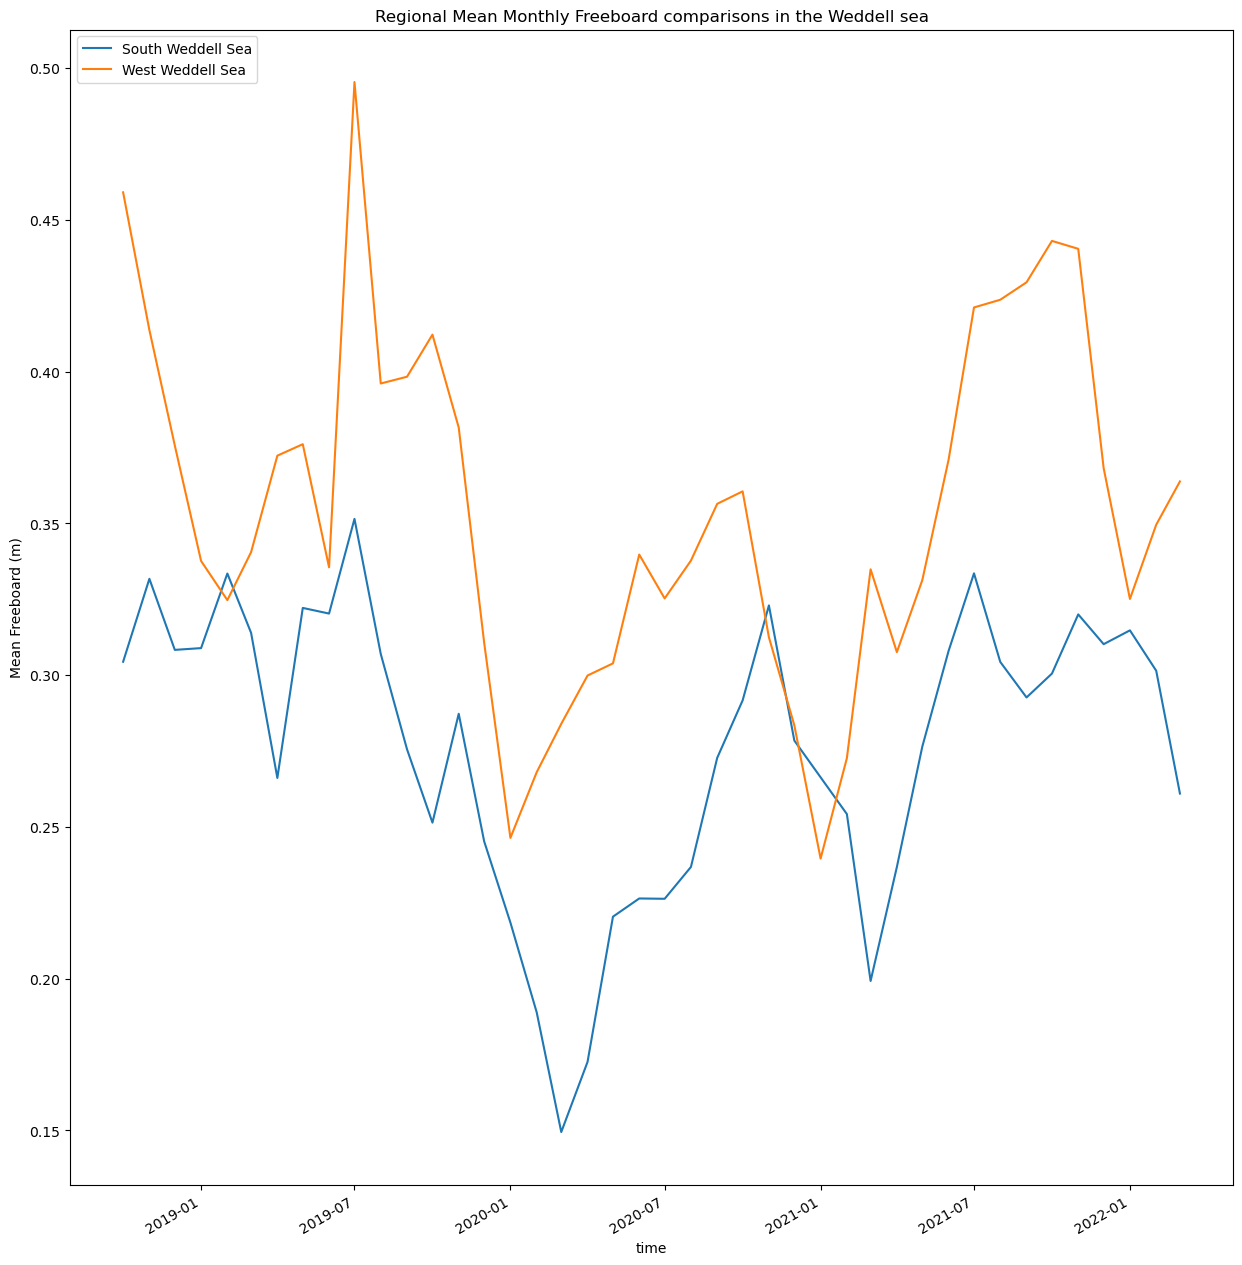

In [5]:
fig, ax = plt.subplots(figsize=(15, 15))
ds.where((ds['grid_x'] > -1225655) & (ds['grid_x'] < -481459) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 1796829))['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot(x='time', ax=ax, label='South Weddell Sea')
ds.where((ds['grid_x'] < -1225655) & (ds['grid_x'] > -2193339) & (ds['grid_y'] >  571532) & (ds['grid_y'] < 2193339))['mean_fb'].mean(dim=['grid_x', 'grid_y']).plot(x='time', ax=ax, label='West Weddell Sea')
plt.legend(loc="upper left")
plt.title('Regional Mean Monthly Freeboard comparisons in the Weddell sea')
plt.ylabel('Mean Freeboard (m)')
# plt.savefig('/g/data/jk72/sc0554/weddellregion_timeseries.png', facecolor='white', transparent=False)

In [ ]:
mean_all = ds['mean_fb'].mean(dim='time')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
west = xr.where((mean_all['grid_x'] < -1225655) & (mean_all['grid_x'] > -2193339) & (mean_all['grid_y'] >  571532) & (mean_all['grid_y'] < 2193339), 20, mean_all)
south = xr.where((west['grid_x'] > -1225655) & (west['grid_x'] < -481459) & (west['grid_y'] >  571532) & (west['grid_y'] < 1796829), 10, west)
south.plot(x='grid_x', y='grid_y', ax=ax)
plt.savefig('/g/data/jk72/sc0554/weddell_regions_epsg3031.png',facecolor='white', transparent=False)

## Create image files

In [ ]:
# Open data
path = '/g/data/jk72/sc0554/ATL20.nc'
data_dir = '/g/data/jk72/MIZ'

ds = xr.open_dataset(path)

In [ ]:
# Create legend

norm=colors.Normalize(vmin=0,vmax=1)
fig=plt.figure(figsize=(1,5))
ax=plt.subplot()
cb=fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap='viridis'),
    label='Sea Ice Freeboard (m)',
    cax=ax,
    extend='max'
    #aspect=2.5
)
# cb.set_ticks([15,30,45,60,75,90,100])

plt.savefig(f'{data_dir}/tracker_files/sea_ice_freeboard_legend.png',
               bbox_inches='tight', transparent="True")

In [ ]:
# Plot example image

cm=plt.get_cmap("viridis")
colored_xr = ds.isel(time=0)['mean_fb'].odc.colorize(cmap=cm, vmin=0, vmax=1)
png_image=Image.fromarray(colored_xr.values,mode="RGBA")
png_image

In [ ]:
mean.coarsen(grid_x=5, boundary='pad').mean().coarsen(grid_y=5, boundary='pad').mean().isel(month=9).plot()

In [ ]:
mean = mean.odc.assign_crs("EPSG:3412")
mean = mean.coarsen(grid_x=5, boundary='pad').mean().coarsen(grid_y=5, boundary='pad').mean()

In [ ]:
mean.isel(month=9).plot()

# Contour testing

In [ ]:
for time in mean['month']:

    month = mean.sel(month=time)
    
    lines=subpixel_contours(month, z_values=[0.2,0.4, 0.6, 0.8, 1.0], min_vertices=10, crs='epsg:3031')

    # Month only filepath
    lines.to_crs('epsg:4326').to_file(
        f'{data_dir}/tracker_files/ATL20_monthly_mean/ATL20_{time.values}.json', 
        driver='GeoJSON'
    )


In [ ]:
lines.plot()


In [ ]:
mean = mean.coarsen(grid_x=6, boundary='pad').mean().coarsen(grid_y=6, boundary='pad').mean().isel(month=8)
x.plot()

In [ ]:
mean.isel(month=8).plot()

In [ ]:
lines=subpixel_contours(x, z_values=[0.5], min_vertices=15, crs='epsg:3031')
lines.plot()

In [ ]:
from pylab import *

cmap = cm.get_cmap('plasma', 5)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

In [ ]:
lines.to_crs('epsg:4326').to_file(
        f'{data_dir}/tracker_files/ATL20/ATL20_test.json', 
        driver='GeoJSON')